# Data Science | Lab: Image Processing
**Table of Contents:**  <a name="toc"></a>
1. [Bag of Visual Words](#bovw)
2. [Histogram of Visual Words](#hovw)
3. [Image Classification](#classification)

# Bag of Visual Words
Analogous to the Bag of Words technique which we covered in the last lab, we will extract "visual" words in order to classify images in this session regarding image processing.

<a name="bovw"></a>
<div style="width: 500px; text-align: center;">
    <img src="https://customers.pyimagesearch.com/wp-content/uploads/2015/09/bovw_image_example.jpg"/>
    <a href="https://customers.pyimagesearch.com/the-bag-of-visual-words-model/" style="">Source</a>
</div>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from sklearn.model_selection import train_test_split
from scipy.cluster.vq import vq
from sklearn.neighbors import NearestCentroid
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import imutils
import cv2

# importing grid search
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.preprocessing import normalize

### Constructing the dataset
- Download the dataset from moodle and extract it into the folder your notebook is in (or adapt the ``directory`` below).
- More information on the Caltech 101 dataset, which contains images of objects belonging to 101 categories, can be found [here](https://data.caltech.edu/records/mzrjq-6wc02).
- Before you start diving into the task, have a look at the datasets' structure and select three different types of images you want to use in this lab session.
- Save the names of the image classes you want to use in ``use_classes``.
- Iterate over all the directories holding images of the classes you chose and save the image paths to variable ``X_paths``.
- For each image path in ``X_paths``, we need its corresponding label saved to ``y``.

In [3]:
# Define the image source folder
directory = "101_ObjectCategories"
# Choose three different classes individually
use_classes = [
    "yin_yang",
    "bonsai",
    "dragonfly"
]

In [4]:
for root, _, files in os.walk(directory):
    n_files = len(files)
    subdir = root.split("\\")[-1]
    if n_files >= 50:
        print(f"{subdir} [{n_files}]")

accordion [55]
airplanes [800]
BACKGROUND_Google [468]
bass [54]
bonsai [128]
brain [98]
buddha [85]
butterfly [91]
camera [50]
car_side [123]
cellphone [59]
chair [62]
chandelier [107]
cougar_face [69]
crab [73]
crayfish [70]
crocodile [50]
crocodile_head [51]
cup [57]
dalmatian [67]
dollar_bill [52]
dolphin [65]
dragonfly [68]
electric_guitar [75]
elephant [64]
emu [53]
euphonium [64]
ewer [85]
Faces [435]
Faces_easy [435]
ferry [67]
flamingo [67]
gramophone [51]
grand_piano [99]
hawksbill [100]
hedgehog [54]
helicopter [88]
ibis [80]
joshua_tree [64]
kangaroo [86]
ketch [114]
lamp [61]
laptop [81]
Leopards [200]
llama [78]
lotus [66]
menorah [87]
minaret [76]
Motorbikes [798]
nautilus [55]
pizza [53]
pyramid [57]
revolver [82]
rhino [59]
schooner [63]
scorpion [84]
sea_horse [57]
soccer_ball [64]
starfish [86]
stegosaurus [59]
stop_sign [64]
sunflower [85]
trilobite [86]
umbrella [75]
watch [239]
wheelchair [59]
windsor_chair [56]
yin_yang [60]


In [5]:
# This variable will store paths to each image
X_paths = []
# This variable will store class id as label
y = []

In [6]:
def extract_photos(directory, use_classes, X_paths, y):
    if len(X_paths) + len(y) != 0:
        X_paths = []
        y = []

    for class_id, class_name in enumerate(use_classes):
        # Get all image paths
        class_folder = os.path.join(directory, class_name)
        image_paths = glob.glob(os.path.join(class_folder, "*.jpg"))

        # Append to the lists
        X_paths.extend(image_paths)
        y.extend([class_name] * len(image_paths))

    return X_paths, y

### Train/Test split
- Perform a train/test split of the dataset (``X`` being image paths, ``y`` being corresponding labels) you constructed.
- Use 80% of data to train the model.
- Be sure to use stratified sampling since not all categories consist of equal number of images.

In [7]:
# TODO:
# perform train/test split

RANDOM_STATE = 42
TEST_SIZE = 0.2

X_paths, y = extract_photos(directory, use_classes, X_paths, y)

X_train, X_test, y_train, y_test = train_test_split(X_paths, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

# Verification
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

print(f"Train labels size: {len(y_train)}")
print(f"Test labels size: {len(y_test)}")



Train size: 204
Test size: 52
Train labels size: 204
Test labels size: 52


### Extract SIFT Features
- Use ``cv2`` ([OpenCV](https://docs.opencv.org/4.9.0/index.html)) to extract meaningful features from images.
- Loop through the image paths you saved in your training set and extract the descriptors of found keypoints using the ``detectAndCompute()`` method of OpenCV's SIFT implementation as described [here](https://docs.opencv.org/4.9.0/d0/d13/classcv_1_1Feature2D.html#a8be0d1c20b08eb867184b8d74c15a677).
- For more information on how to use SIFT in OpenCV, check this [tutorial](https://docs.opencv.org/4.9.0/da/df5/tutorial_py_sift_intro.html).

In [8]:
sift = cv2.SIFT_create()

def extract_descriptors(image_paths):
    desc_list = []

    for image_path in image_paths:

        img = cv2.imread(image_path)

        kp, des = sift.detectAndCompute(img, mask=None)

        desc_list.append(des)

    return desc_list


In [9]:
train_desc_list = extract_descriptors(X_train)

display(len(train_desc_list))
display(len(X_train))


204

204

### Clustering
- We want to assign similar descriptors to clusters that represent the idea of visual words in our images.
- To do this, use the K-Means clustering method to extract clusters of descriptors from the descriptors found in all images of the training set.
    - If you want to use [sklearn's](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) K-Means implementation, you need to parameterize it to reduce runtime (i.e., set ``n_init``, minimize ``max_iter``).
    - You can also rely on [OpenCV](https://docs.opencv.org/4.x/d1/d5c/tutorial_py_kmeans_opencv.html), as it provides a faster implementation of K-Means.
- In any case, we want to set ``k=100`` as the number of clusters that are to be applied to the keypoint descriptors computed by SIFT. 

<div class="alert alert-block alert-info">
    <b>Caution:</b> As we applied SIFT feature extraction to each image individually, you will have to flatten <tt>train_desc_list</tt> in order to perform the clustering correctly.
</div>

In [10]:
# TODO: Stack all the descriptors of train_desc_list vertically in a numpy array
train_descriptors = np.vstack(train_desc_list)
print(f"Shape of train_descriptors: {train_descriptors.shape}")

Shape of train_descriptors: (86897, 128)


In [11]:
NUMBER_OF_CLUSTERS = 100

# KMeans
kMeansClassifier = KMeans(
    n_clusters=NUMBER_OF_CLUSTERS,
    n_init=1,
    max_iter=100,
    verbose=0,
    init='k-means++')

# train the kMeansClassifier
kMeansClassifier.fit(train_descriptors)

KMeans(max_iter=100, n_clusters=100, n_init=1)

# Histogram of Visual Words
- In the next step, we want to apply the trained K-Means model to the descriptors of each image individually.
- This way, we create a histogram denoting counts of feature clusters for every single image.
- Think about it this way:
    - Before this step, the number of descriptors found by SIFT may be different for each image.
    - After we apply K-Means to each set of descriptors of a image, every image has a vector of length ``k`` that describes the visual words found in this image as they were computed from the whole training set.

<a name="hovw"></a>
<div style="width: 500px; text-align: center;">
    <img src="https://miro.medium.com/max/625/1*QgI1t-7yJApi4vQigFgsLQ.jpeg"/>
    <a href="https://towardsdatascience.com/bag-of-visual-words-in-a-nutshell-9ceea97ce0fb" style="">Source</a>
</div>

### Constructing histogram with ``compute_feature_histogram(...)``
- Suppose we set ``k=100`` and therefore computed 100 clusters from the descriptor list and we have 250 images in the training dataset.
- ``compute_feature_histogram(...)`` should create a vector for each image (250 in this example) containing ``k=100`` elements.
- Hence the shape of its return value will be ``(250, 100)``.
- Remember that every image contains an arbitary number of descriptors found in it, thus we need to loop over the images separately to compute each histogram correctly.
- Be sure to also apply the construction of histograms to your test set as well!
- You may need to apply ``extract_features(...)`` to your testing set if you did not do so already. 

In [12]:
def compute_feature_histogram(_model, _desc_list, _k, normalization=None):
    # Compute feature histogram
    _bovw_features = np.zeros((len(_desc_list), _k), "float32")
    for i, descr in enumerate(_desc_list):
        labels = _model.predict(descr)  # here we have clusters for the descriptors of an image
        # TODO: compute histogram and store in _bovw_features
        histogram, _ = np.histogram(labels, bins=np.arange(_k + 1))
        _bovw_features[i, :] = histogram

    if normalization is not None:
        _bovw_features = normalize(_bovw_features, norm=normalization)

    return _bovw_features

In [13]:
train_bovw_features = compute_feature_histogram(kMeansClassifier, train_desc_list, 100)

#### Ploting the histogram to check if the function works

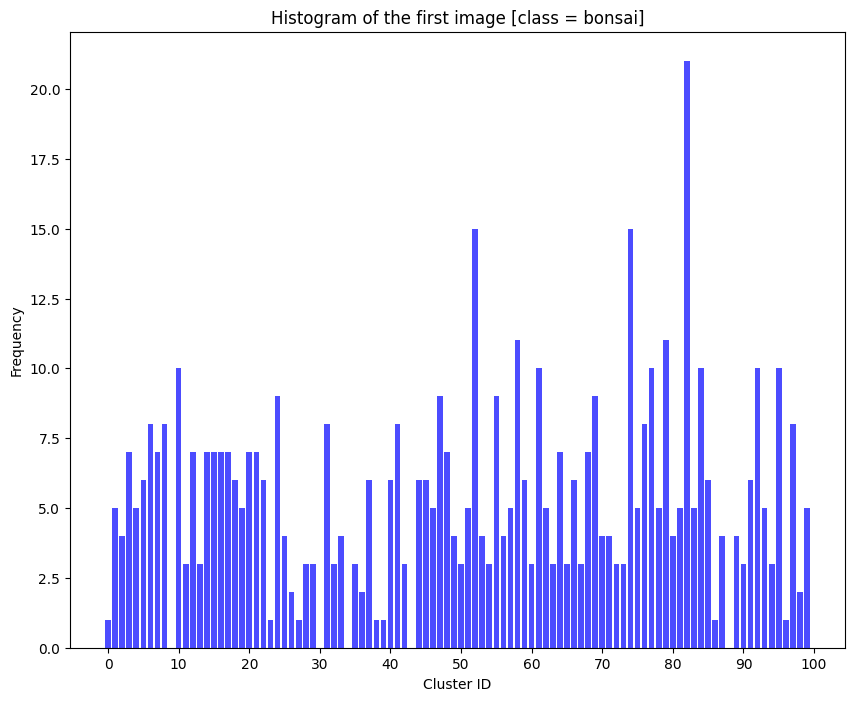

In [14]:
first_histogram = train_bovw_features[1]
length = len(first_histogram)

# print a hsitogram of the first image
plt.figure(figsize=(10, 8))
plt.title(f"Histogram of the first image [class = {y_train[150]}]")
plt.bar(range(length), first_histogram, width=0.8, color='blue', alpha=0.7)
plt.xlabel("Cluster ID")
plt.xticks(np.array(range(0, length+1, 10)))
plt.ylabel("Frequency")
plt.show()


# Image Classification
<a name="classification"></a>
- Finally, train a MinDist classifier on the training set and predict the category of each image in the test set.
- As always, remember that in scikit-learn, MinDist is called [Nearest Centroid](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html?highlight=nearest%20centroid#sklearn.neighbors.NearestCentroid).
- Evaluate your classifier's performance by plotting the confusion matrix!


Accuracy: 0.8076923076923077


Text(0.5, 1.0, 'Confusion Matrix')

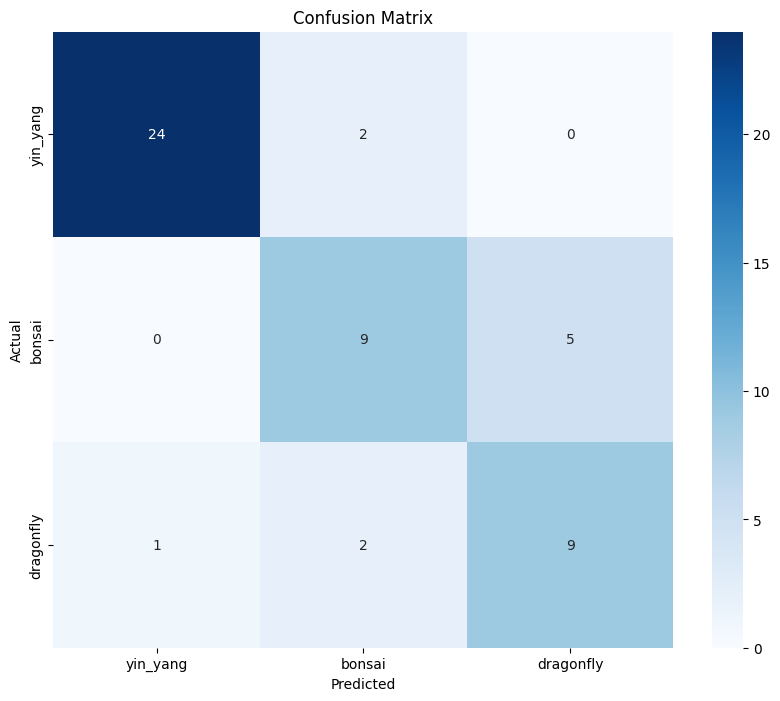

In [15]:
# TODO: implement image classification steps described above!
classifier = NearestCentroid()

test_desc_list = extract_descriptors(X_test)
test_bovw_features = compute_feature_histogram(kMeansClassifier, test_desc_list, 100)

classifier.fit(train_bovw_features, y_train)
classifier_predictions = classifier.predict(test_bovw_features)

accuracy = accuracy_score(y_test, classifier_predictions)

print(f"Accuracy: {accuracy}")

# Display the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, classifier_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=np.arange(len(use_classes)) + 0.5, labels=use_classes)
plt.yticks(ticks=np.arange(len(use_classes)) + 0.5, labels=use_classes)
plt.title("Confusion Matrix")


## Homework Assignment

Extend your code to include the following:
1. Extend your dataset to use 5 different individually chosen categories of images.
2. Set up a grid search for at least three different ``k`` for K-Means and two different distance ``metric``s for MinDist.
3. Evaluate the grid with 3-fold (stratified) cross validation with ``accuracy`` as the scoring method.
4. Check if histogram normalization has an influence on your results by including it as an option in your grid search.
5. Plot the confusion matrix for the test dataset using the best setting according to the grid search.
6. Document your findings (see final comment in section Moodle Upload on the topics to include in your findings).


## Moodle Upload
This is an **indivdual** assignment, meaning that you are graded individually. If you have collaborated with colleagues during the lab, make sure to state **all** of their names at the beginning of the document. The final document **must** exhibit individual efforts (structure, variable settings, reasoning, interpretation) despite some inherent similarities. 

Upload your notebook as ``firstname_lastname_ip.html`` to Moodle. 

Make sure to consider the following:
* Have all your import statements in one single cell at the top of the notebook.
* Remove unnecessary code.
* Include a markdown cell at the end where you:
    * give a short overview of what your notebook is about
    * be sure to describe BOVW in your own words: Which steps are necessary? How does it relate to the BoW-concept from NLP? What are "words" and "documents" in this context?
    * describe and interpret your settings and justify your choices
    * analyze the final/best results

# HOMEWORK

#### Expanding dataset to 5 different classes and testing accuracy

Accuracy: 0.6923076923076923


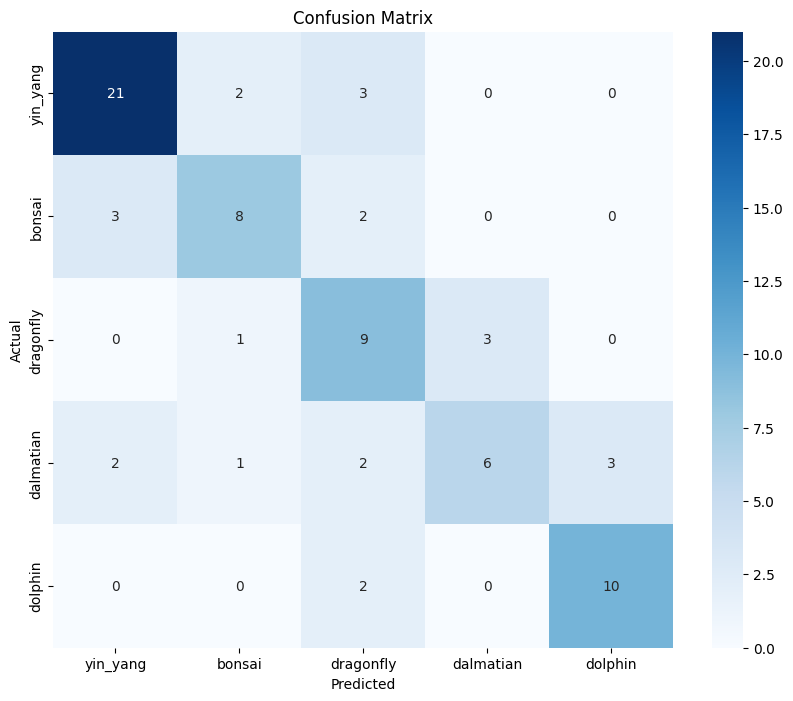

In [16]:
# seelct classes for analysis
selected_classes = [
    "yin_yang",
    "bonsai",
    "dragonfly",
    'dalmatian',
    'dolphin'
]

# extract paths

X_paths, y = extract_photos(directory, selected_classes, X_paths, y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_paths, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

# extract descriptors
train_desc_list = extract_descriptors(X_train)
train_descriptors = np.vstack(train_desc_list)

test_desc_list = extract_descriptors(X_test)
test_descriptors = np.vstack(test_desc_list)


# classifier
classifier = NearestCentroid()

# extract hisograms
train_bovw_features = compute_feature_histogram(kMeansClassifier, train_desc_list, 100)
test_bovw_features = compute_feature_histogram(kMeansClassifier, test_desc_list, 100)

# fit the classifier
classifier.fit(train_bovw_features, y_train)
classifier_predictions = classifier.predict(test_bovw_features)

accuracy = accuracy_score(y_test, classifier_predictions)

print(f"Accuracy: {accuracy}")

# Display the confusion matrix
cm = confusion_matrix(y_test, classifier_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=np.arange(len(selected_classes)) + 0.5, labels=selected_classes)
plt.yticks(ticks=np.arange(len(selected_classes)) + 0.5, labels=selected_classes)
plt.title("Confusion Matrix")

plt.show()


## Grid Search 

In [ ]:
# kMeans constants
n_init = 1
max_iter = 100
init = ['k-means++']

# hyperparameters to test
parameters = {
    'n_clusters': [10, 50, 100, 150, 200],
    'metric': ['euclidean', 'manhattan'],
    'normalization': [None, 'l1', 'l2']
}

# cross validation setup
k_folds = 3
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# results
best_kmeans = None
best_n_clusters = None
best_overall_score = float("-inf")
best_metric = None
best_normalization = None

for pg in ParameterGrid(parameters):
    fold_scores = []

    for train_idx, test_idx in skf.split(train_desc_list, y_train):
        X_train_fold = [train_desc_list[i] for i in train_idx if train_desc_list[i] is not None]
        X_test_fold = [train_desc_list[i] for i in test_idx if train_desc_list[i] is not None]

        y_train_fold = [y_train[i] for i in train_idx]
        y_test_fold = [y_train[i] for i in test_idx]


        X_train_stacked = np.vstack(X_train_fold)

        kmeans = KMeans(
            n_clusters=pg['n_clusters'],
            n_init=n_init,
            max_iter=max_iter,
            verbose=0,
            init='k-means++'
        )
        kmeans.fit(X_train_stacked)

        train_bovw_features = compute_feature_histogram(kmeans, X_train_fold, pg['n_clusters'], normalization=pg['normalization'])
        test_bovw_features = compute_feature_histogram(kmeans, X_test_fold, pg['n_clusters'], normalization=pg['normalization'])

        classifier = NearestCentroid(metric=pg['metric'])
        classifier.fit(train_bovw_features, y_train_fold)

        #predict on test set
        classifier_predictions = classifier.predict(test_bovw_features)

        # compute acc
        accuracy = accuracy_score(y_test_fold, classifier_predictions)
        fold_scores.append(accuracy)

    # compute avg acc for the current fold
    mean_score = np.mean(fold_scores)
    print(f" Accuracy: {mean_score:.4f} [n_clusters={pg['n_clusters']}, metric={pg['metric']}, normalization={pg['normalization']}]")

    if mean_score > best_overall_score:
        best_overall_score = mean_score
        best_kmeans = kmeans
        best_n_clusters = pg['n_clusters']
        best_metric = pg['metric']
        best_normalization = pg['normalization']

print(f"Best overall accuracy: {best_overall_score * 100:.4f}%")
print(f"Best n_clusters: {best_n_clusters}")
print(f"Best metric: {best_metric}")
print(f"Best normalization: {best_normalization}")

 Accuracy: 0.4549 [n_clusters=10, metric=euclidean, normalization=None]
 Accuracy: 0.5869 [n_clusters=10, metric=euclidean, normalization=l1]
 Accuracy: 0.5967 [n_clusters=10, metric=euclidean, normalization=l2]
 Accuracy: 0.5613 [n_clusters=50, metric=euclidean, normalization=None]
 Accuracy: 0.6708 [n_clusters=50, metric=euclidean, normalization=l1]


## Selecting best parameters and creating confusion matrix

Accuracy: 76.9231%


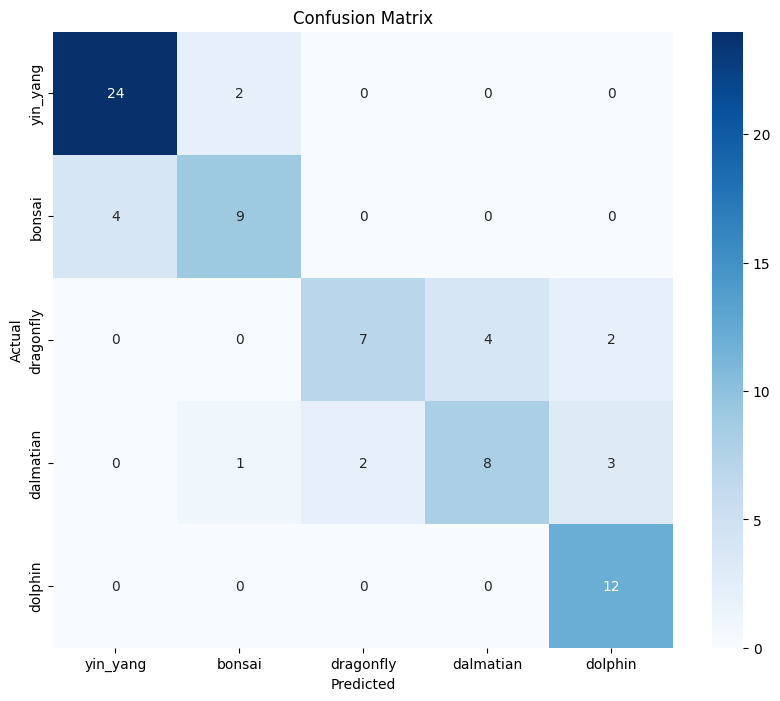

In [90]:
kmeans = best_kmeans

train_bovw_features = compute_feature_histogram(kmeans, train_desc_list, best_n_clusters, normalization=best_normalization)
test_bovw_features = compute_feature_histogram(kmeans, test_desc_list, best_n_clusters, normalization=best_normalization)

classifier = NearestCentroid(metric=best_metric)
classifier.fit(train_bovw_features, y_train)
classifier_predictions = classifier.predict(test_bovw_features)

accuracy = accuracy_score(y_test, classifier_predictions)
print(f"Accuracy: {accuracy*100:.4f}%")

cm = confusion_matrix(y_test, classifier_predictions)
plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.xticks(ticks=np.arange(len(selected_classes)) + 0.5, labels=selected_classes)
plt.yticks(ticks=np.arange(len(selected_classes)) + 0.5, labels=selected_classes)
plt.title("Confusion Matrix")

plt.show()

# Conclusions

#### **What this notebook is about :**

This notebook focuses on image classification using the Bag of Visual Words (BoVW) model, inspired by the Bag of Words (BoW) approach from NLP. The main goal is to extract meaningful features from images, cluster them into a visual vocabulary, and use these clusters as features for classification.

To achieve this, the workflow consists of:

1. Extracting local features from images using SIFT descriptors.
2. Creating a "visual vocabulary" by clustering descriptors with KMeans.
3. Representing each image as a histogram of visual words (BoVW).
4. Training a classifier (Nearest Centroid) to predict image categories based on BoVW histograms.
5. Tuning hyperparameters such as the number of clusters, distance metrics, and normalization using cross-validation to achieve optimal performance.

#### **BoVW in my words :**

Bag of visual words approach is inspired by Bag of Words approach in Natural Language Processing, where each document is epresented by a frequency of words it contains. On the other hand the BoVW define *visual words* by clustering local features that we extracted from images


**Steps :**
1. Extracting keypoint descriptors from the images using SIFT
2. Using kMeans to group similar descriptors into clusters. Each cluster center represents a common pattern
3. Assigning descriptors to closest cluster
4. Creating a histogram of "cluster appearances", which acts as the feature vector
5. Training NearestCentroid classifier using feature vector to predict the image category based on the clustter appearances distribution

**How does it relate to BoW concept from NLP :**
- in IP we trat images as a documents, and in NLP we trat text files / tex documents as documents
- in IP we treat clustered keypoints as "words" and in NLP we treat individual words or conglomeration of words  as "words"
- in IP we represent featuresas histograms, where in NLP we represent features as word frequency vectors


#### **Describe and interpret your settings and justify your choices :**
As hyperparameters to optimize in the grid search, I chose:

- Number of clusters (n_clusters): [10, 50, 100, 150, 200]
- Type of normalization: [None, 'l1', 'l2']
- Distance metric for classification: ['euclidean', 'manhattan']

The best results were achieved with:

- KMeans with 100 clusters, which provided the best balance between granularity and efficiency
- L1 normalization, which helped standardize feature values, preventing bias from varying descriptor counts
- Euclidean distance, which performed better, possibly due to the distribution of visual word histograms, making it a more suitable similarity measure


#### **Analyzing the best/results :**
**ying-yang and dolphin had the best results:**
- "yin_yang" has 24 correctly classified instances and only 2 misclassifications as "bonsai".
- "dolphin" has perfect classification with 12 correct predictions and no misclassifications.


**bonsai and dragonfly had moderate performance:**
- "bonsai" has 9 correct classifications but 4 misclassified as "yin_yang".
- "dragonfly" has 7 correct classifications, but 4 were misclassified as "dalmatian" and 2 as "dolphin".

**dalmatian and dragonfly :**
- "dalmatian" has 8 correct classifications, but 3 were misclassified as "dolphin" and 2 as "dragonfly".
- "dragonfly" was often confused with "dalmatian" (4 times).

**Conclusions about he results :**
- "ying_yang" and "doplhin" have distinctive features, making them easy to classify
- "bonsai" and "yin_yang" might share similar textures or shapes, leading to confusion
- "dragonfly" and "dalmatian" might have overlapping features
- Model might struggle to differentiate between spotted patterns (dalmatian) and dragonfly features
- "dolphin", "dalmatian" and "dragonfly" were misclassified the most, possibly due to their similar shapes and textures, which may have caused their descriptors to be clustered in a similar way.
- "yin_yang" has significantly more images than the other classes, which may indicate that the model learned its dominant patterns better, leading to higher classification accuracy for this category.
- Overall, the model performed well, but there is still room for improvement, particularly in distinguishing visually similar classes.
